# Future Network Constrained Linear Optimal Power Flow

PyPSA-GB can model the GB power system  by solving a network constrained Linear Optimal Power Flow (LOPF) problem. This notebook shows the example application of a future 3 day period.

In [1]:
import os
from dotenv import find_dotenv, load_dotenv

load_dotenv(find_dotenv())
src_path = os.environ.get('PROJECT_SRC')
os.chdir(src_path)

In [2]:
import pypsa
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 22})
import pandas as pd
import cartopy.crs as ccrs

import data_reader_writer

## Setting up simulation

Set the required inputs for the LOPF: the start, end and year of simulation, and the timestep.

In [3]:
# write csv files for import
start = '2050-06-04 00:00:00'
end = '2050-06-06 23:30:00'
# year of simulation
year = int(start[0:4])
# time step as fraction of hour
time_step = 0.5

Choose from one of the National Grid Future Energy Scenarios.

In [4]:
scenario = 'Leading The Way'
# scenario = 'Consumer Transformation'
# scenario = 'System Transformation'
# scenario = 'Steady Progression'

Choose a baseline year (from 2010-2020). The baseline year determines which historical load profile and weather dataset is used for the future year modelled. The National Grid FES modellers used 2012 as their baseline year.

In [5]:
year_baseline = 2019

data_reader_writer is a script written to read in data from the various sources and write csv files in the format required for populating a PyPSA network object

In [6]:
data_reader_writer.data_writer(start, end, time_step, year, year_baseline=year_baseline,
                               scenario=scenario, merge_generators=True)

C:\Users\alyden\Anaconda3\envs\PyPSA-GB\lib\site-packages\pandas\core\arrays\datetimes.py:741: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex
  warnings.warn(
C:\Users\alyden\Anaconda3\envs\PyPSA-GB\lib\site-packages\pandas\core\indexing.py:1667: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = value
C:\Users\alyden\OneDrive - University of Edinburgh\Python\PyPSA-GB v0.0.1\PyPSA-GB\interconnectors.py:201: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  df_FES = df_FES[~df_FES.Variable.str.contains('(TWh)')]


In [7]:
network = pypsa.Network()

network.import_from_csv_folder('LOPF_data')

Importing PyPSA from older version of PyPSA than current version.
Please read the release notes at https://pypsa.readthedocs.io/en/latest/release_notes.html
carefully to prepare your network for import.
Currently used PyPSA version [0, 19, 2], imported network file PyPSA version None.

INFO:pypsa.components:Applying weightings to all columns of `snapshot_weightings`
INFO:pypsa.io:Imported network LOPF_data has buses, generators, lines, links, loads, storage_units


Lines need to be scaled up to accomadate for future generation, and specific analysis will be done on this in a later notebook.
Note: interconnects are links in future, so don't need to be selective here (as was required in historical simulation).

In [8]:
contingency_factor = 4
network.lines.s_max_pu *= contingency_factor

## Running the optimisation

In [9]:
network.lopf(network.snapshots, solver_name="gurobi", pyomo=False)

INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 3.64s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Set parameter Username
Academic license - for non-commercial use only - expires 2022-09-03
Read LP format model from file C:\Users\alyden\AppData\Local\Temp\pypsa-problem-q64kptni.lp
Reading time = 1.75 seconds
obj: 644084 rows, 182017 columns, 1130397 nonzeros
Gurobi Optimizer version 9.5.1 build v9.5.1rc2 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 644084 rows, 182017 columns and 1130397 nonzeros
Model fingerprint: 0x4b814fe1
Coefficient statistics:
  Matrix range     [6e-05, 1e+00]
  Objective range  [5e-01, 5e+08]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-04, 1e+09]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 623068 rows and 117187 columns
Presolve time: 0.66s
Presolved: 21016 rows, 65974 columns, 127787 nonzeros

Ordering time: 0.23s

Barrier statistics:
 AA' NZ     : 5.503e+04
 Factor NZ  : 9.687e+05 (roughly 40 MB of memory)
 Factor Ops : 1.284e+08 (l

INFO:pypsa.linopf:Optimization successful. Objective value: 1.86e+14


('ok', 'optimal')

## Power output by generation type

Group the generators by the carrier, and print their summed power outputs over the simulation period.

In [10]:
p_by_carrier = network.generators_t.p.groupby(
    network.generators.carrier, axis=1).sum()

storage_by_carrier = network.storage_units_t.p.groupby(
    network.storage_units.carrier, axis=1).sum()

# to show on graph set the negative storage values to zero
storage_by_carrier[storage_by_carrier < 0] = 0

p_by_carrier = pd.concat([p_by_carrier, storage_by_carrier], axis=1)

print(network.links_t.p0)
imp = network.links_t.p0.copy()
imp[imp < 0] = 0
imp['Interconnectors Import'] = imp.sum(axis=1)
interconnector_import = imp[['Interconnectors Import']]
print(interconnector_import)

p_by_carrier = pd.concat([p_by_carrier, interconnector_import], axis=1)

exp = network.links_t.p0.copy()
exp[exp > 0] = 0
exp['Interconnectors Export'] = exp.sum(axis=1)
interconnector_export = exp[['Interconnectors Export']]
print(interconnector_export)

# group biomass stuff
p_by_carrier['Biomass'] = (
    p_by_carrier['Biomass (dedicated)'] + p_by_carrier['Biomass (co-firing)'] +
    p_by_carrier['Landfill Gas'] + p_by_carrier['Anaerobic Digestion'] +
    p_by_carrier['Sewage Sludge Digestion'])

# rename the hydro bit
p_by_carrier = p_by_carrier.rename(
    columns={'Large Hydro': 'Hydro'})
p_by_carrier = p_by_carrier.rename(
    columns={'Interconnector': 'Interconnectors Import'})

p_by_carrier

Link                 BritNed  EastWest       Moyle  Nemo     IFA    IFA2  \
snapshot                                                                   
2050-06-04 00:00:00      0.0       0.0  150.721939   0.0 -3500.0  1750.0   
2050-06-04 00:30:00      0.0       0.0  116.861714   0.0   700.0  1750.0   
2050-06-04 01:00:00      0.0       0.0  100.411522   0.0   700.0 -1750.0   
2050-06-04 01:30:00      0.0       0.0  101.369956   0.0   700.0  1750.0   
2050-06-04 02:00:00      0.0       0.0  117.079990   0.0   700.0 -1750.0   
...                      ...       ...         ...   ...     ...     ...   
2050-06-06 21:30:00      0.0       0.0  607.984418   0.0   700.0 -1750.0   
2050-06-06 22:00:00      0.0       0.0  534.720819   0.0  -700.0  1750.0   
2050-06-06 22:30:00      0.0       0.0  547.909799   0.0  -700.0 -1750.0   
2050-06-06 23:00:00      0.0       0.0  647.282601   0.0  -700.0  1750.0   
2050-06-06 23:30:00      0.0       0.0  647.267123   0.0   700.0  1750.0   

Link       

,Anaerobic Digestion,Biomass (co-firing),Biomass (dedicated),CCS Biomass,CCS Gas,EfW Incineration,Hydrogen,Landfill Gas,Hydro,Marine,...,Solar Photovoltaics,Unmet Load,Wind Offshore,Wind Onshore,Battery,Compressed Air,Liquid Air,Pumped Storage Hydroelectric,Interconnectors Import,Biomass
snapshot,,,,,,,,,,,,,,,,,,,,,
2050-06-04 00:00:00,314.1,79.424,398.31136,4867.38,0.0,831.12156,14575.099000,734.8,112.080749,531.0,...,0.0,478.704252,24566.263255,6127.756899,0.000000,8.204355,0.000000,1229.621980,7850.721939,1576.83536
2050-06-04 00:30:00,314.1,79.424,398.31136,4867.38,0.0,831.12156,14575.099000,734.8,111.514685,531.0,...,0.0,745.856605,23463.301519,5812.797002,0.000000,77.643181,5.929731,746.801980,6766.861714,1576.83536
2050-06-04 01:00:00,314.1,79.424,398.31136,4867.38,0.0,831.12156,14575.099000,734.8,111.514685,531.0,...,0.0,1335.838847,23312.104455,5397.702156,0.000000,0.000000,48.090881,746.801980,6750.411522,1576.83536
2050-06-04 01:30:00,314.1,79.424,398.31136,4867.38,0.0,831.12156,14575.099000,734.8,111.514685,531.0,...,0.0,961.637549,23081.070594,4883.831438,42.964566,9.115984,0.000000,1636.505334,6751.369956,1576.83536
2050-06-04 02:00:00,314.1,79.424,398.31136,4867.38,0.0,831.12156,14575.099000,734.8,111.514685,531.0,...,0.0,1662.123274,23102.304465,4356.962357,34.903275,0.000000,0.000000,746.801980,6767.079990,1576.83536
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2050-06-06 21:30:00,314.1,79.424,398.31136,0.00,0.0,831.12156,14459.214000,734.8,382.659525,531.0,...,0.0,0.000000,28738.049487,2831.395373,11606.404016,2026.209930,1173.410184,3781.533664,7257.984418,1576.83536
2050-06-06 22:00:00,314.1,79.424,398.31136,0.00,0.0,831.12156,14459.214000,734.8,288.126772,531.0,...,0.0,0.000000,28902.314228,2931.132115,11602.567111,562.802538,271.693760,3781.533664,7184.720819,1576.83536
2050-06-06 22:30:00,314.1,79.424,398.31136,0.00,0.0,831.12156,13410.982482,734.8,287.560709,531.0,...,0.0,0.000000,29983.092663,3188.721072,6873.524892,674.760988,965.082161,3781.533664,7197.909799,1576.83536


Graph the power output of the different generation types...

C:\Users\alyden\Anaconda3\envs\PyPSA-GB\lib\site-packages\pandas\plotting\_matplotlib\core.py:1391: UserWarning: Attempting to set identical bottom == top == 0.0 results in singular transformations; automatically expanding.
  ax.set_ylim(None, 0)


Text(0.5, 0, '')

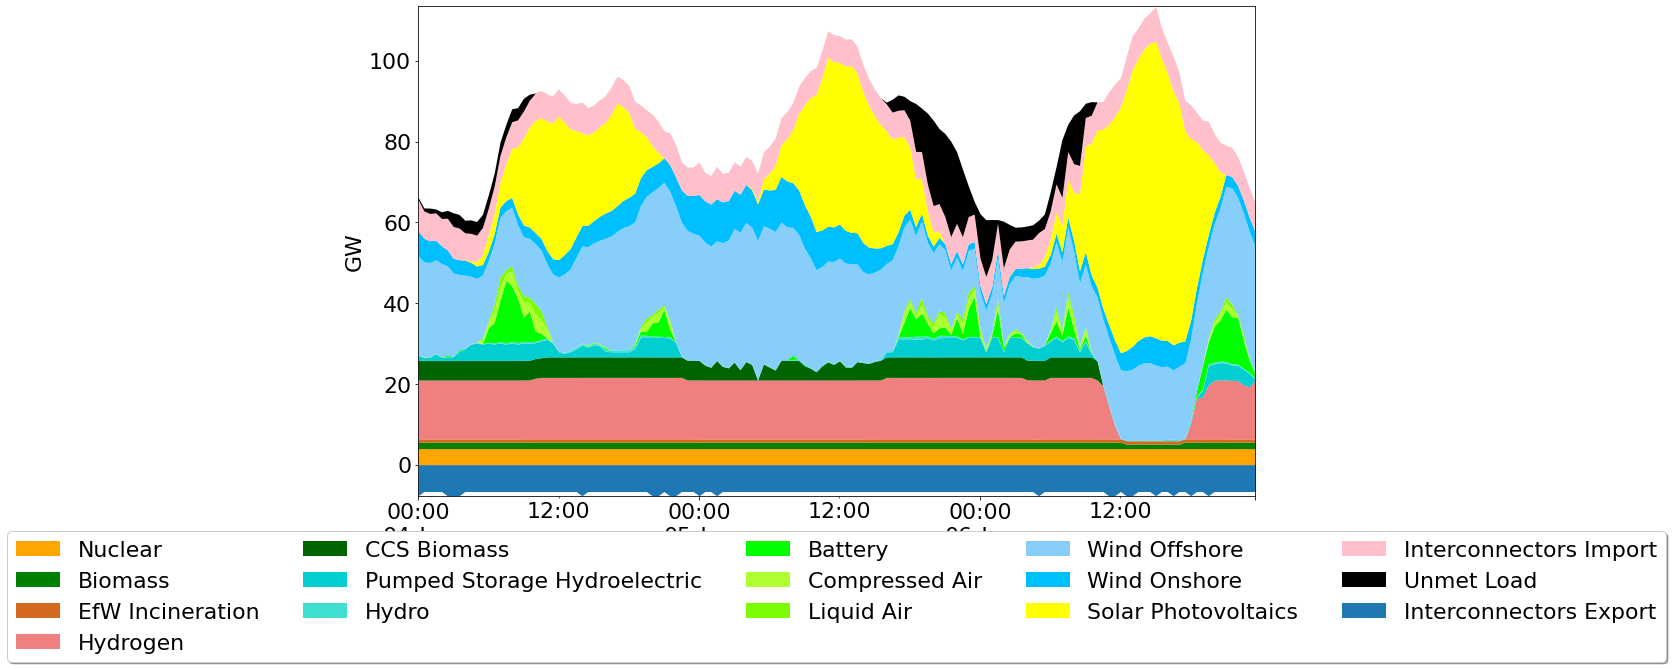

In [11]:
cols = ["Nuclear", 'Biomass',
        'EfW Incineration', "Oil", "Natural Gas",
        'Hydrogen', 'CCS Gas', 'CCS Biomass',
        "Pumped Storage Hydroelectric", 'Hydro',
        'Battery', 'Compressed Air', 'Liquid Air',
        "Wind Offshore", 'Wind Onshore', 'Solar Photovoltaics',
        'Interconnectors Import', 'Unmet Load'
        ]

p_by_carrier = p_by_carrier[cols]

p_by_carrier.drop(
    (p_by_carrier.max()[p_by_carrier.max() < 50.0]).index,
    axis=1, inplace=True)


colors = {"Coal": "grey",
          "Diesel/Gas oil": "black",
          "Diesel/gas Diesel/Gas oil": "black",
          'Oil': 'black',
          'Unmet Load': 'black',
          'Anaerobic Digestion': 'green',
          'EfW Incineration': 'chocolate',
          'Sewage Sludge Digestion': 'green',
          'Landfill Gas': 'green',
          'Biomass (dedicated)': 'green',
          'Biomass (co-firing)': 'green',
          'Biomass': 'green',
          'CCS Biomass': 'darkgreen',
          'Interconnectors Import': 'pink',
          "Sour gas": "lightcoral",
          "Natural Gas": "lightcoral",
          'CCS Gas': "lightcoral",
          'Hydrogen': "lightcoral",
          "Nuclear": "orange",
          'Shoreline Wave': 'aqua',
          'Tidal Barrage and Tidal Stream': 'aqua',
          'Hydro': "turquoise",
          "Large Hydro": "turquoise",
          "Small Hydro": "turquoise",
          "Pumped Storage Hydroelectric": "darkturquoise",
          'Battery': 'lime',
          'Compressed Air': 'greenyellow',
          'Liquid Air': 'lawngreen',
          "Wind Offshore": "lightskyblue",
          'Wind Onshore': 'deepskyblue',
          'Solar Photovoltaics': 'yellow'}

fig, ax = plt.subplots(1, 1)
fig.set_size_inches(15,10)
(p_by_carrier / 1e3).plot(
    kind="area", ax=ax, linewidth=0,
    color=[colors[col] for col in p_by_carrier.columns])

# stacked area plot of negative values, prepend column names with '_' such that they don't appear in the legend
(interconnector_export / 1e3).plot.area(ax=ax, stacked=True, linewidth=0.)
# rescale the y axis
ax.set_ylim([(interconnector_export / 1e3).sum(axis=1).min(), (p_by_carrier / 1e3).sum(axis=1).max()])

# Shrink current axis's height by 10% on the bottom
box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.1,
                 box.width, box.height * 0.9])

# Put a legend below current axis
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
          fancybox=True, shadow=True, ncol=5)

ax.set_ylabel("GW")

ax.set_xlabel("")

## Plotting storage

Graph the pumped hydro dispatch and state of charge...

Text(0.5, 0, '')

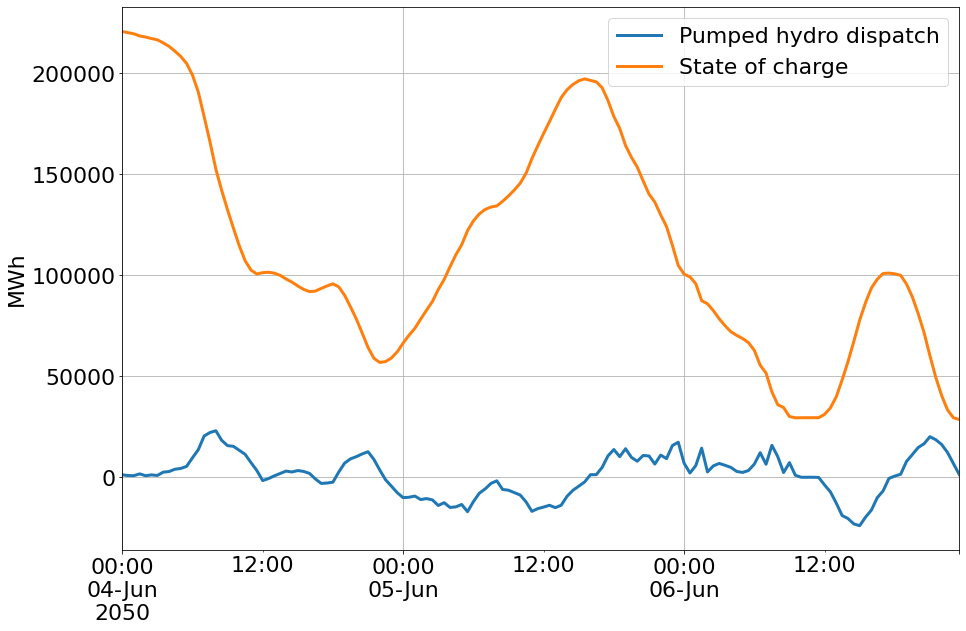

In [12]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(15,10)

p_storage = network.storage_units_t.p.sum(axis=1)
state_of_charge = network.storage_units_t.state_of_charge.sum(axis=1)
p_storage.plot(label="Pumped hydro dispatch", ax=ax, linewidth=3)
state_of_charge.plot(label="State of charge", ax=ax, linewidth=3)

ax.legend()
ax.grid()
ax.set_ylabel("MWh")
ax.set_xlabel("")

## Plotting line loading

Look at the line loading stats and graph...

In [13]:
now = network.snapshots[139]

print("With the linear load flow, there is the following per unit loading:")
loading = network.lines_t.p0.loc[now] / network.lines.s_nom
loading.describe()

With the linear load flow, there is the following per unit loading:


count    99.000000
mean      0.164535
std       0.860010
min      -1.985558
25%      -0.180409
50%       0.069719
75%       0.350688
max       4.000000
dtype: float64

(<matplotlib.collections.PatchCollection at 0x19e1c032b80>,
 <matplotlib.collections.LineCollection at 0x19e1be16400>)

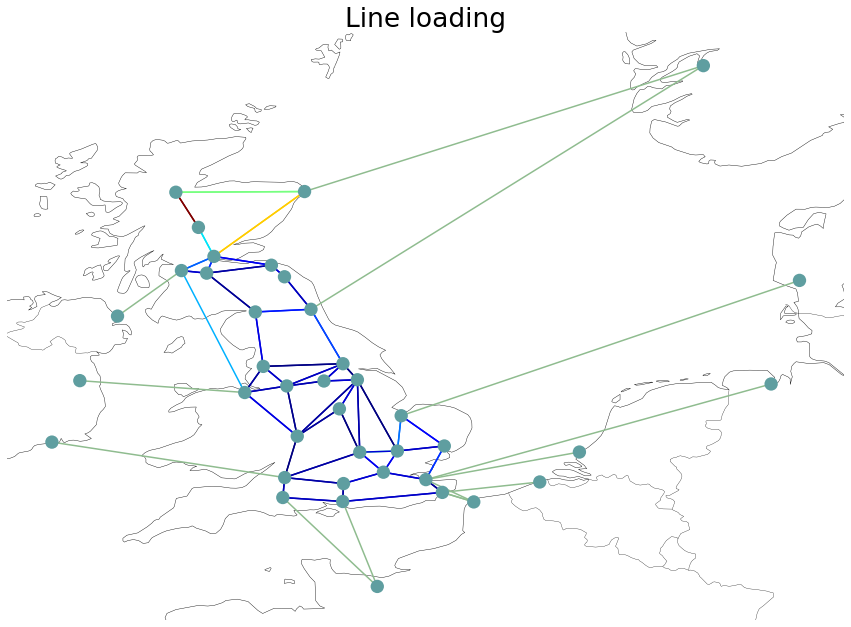

In [14]:
fig, ax = plt.subplots(1, 1, subplot_kw={"projection": ccrs.PlateCarree()})
fig.set_size_inches(15, 17)

network.plot(ax=ax, line_colors=abs(loading), line_cmap=plt.cm.jet, title="Line loading")

## Plotting locational marginal prices

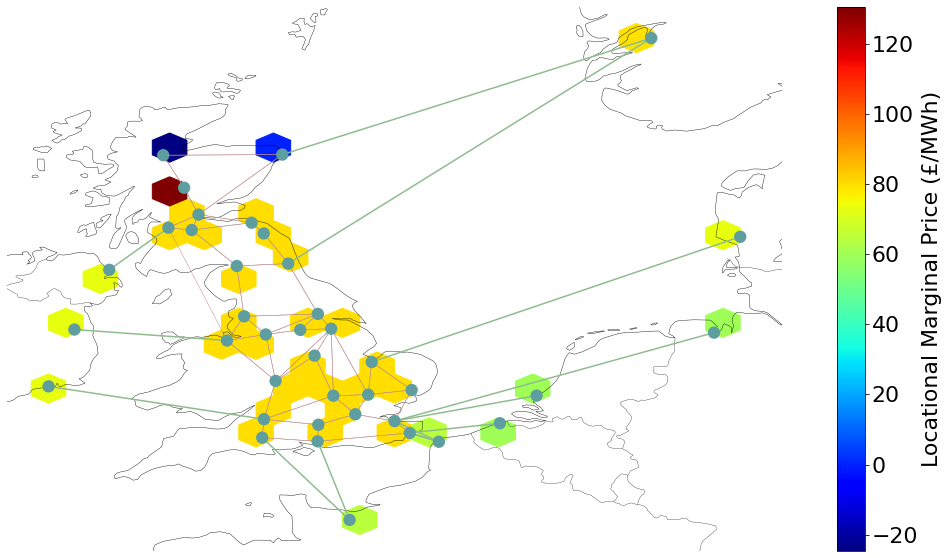

In [15]:
fig, ax = plt.subplots(1, 1, subplot_kw={"projection": ccrs.PlateCarree()})
fig.set_size_inches(20, 10)

network.plot(ax=ax, line_widths=pd.Series(0.5, network.lines.index))
plt.hexbin(network.buses.x, network.buses.y,
           gridsize=20,
           C=network.buses_t.marginal_price.loc[now],
           cmap=plt.cm.jet)

# for some reason the colorbar only works with graphs plt.plot
# and must be attached plt.colorbar

cb = plt.colorbar()
cb.set_label('Locational Marginal Price (£/MWh)')

In [16]:
network.buses_t.marginal_price

Bus,Beauly,Peterhead,Errochty,Denny/Bonnybridge,Neilston,Strathaven,Torness,Eccles,Harker,Stella West,...,Netherlands,Belgium,France1,France2,Ireland,N. Ireland,Ireland2,Denmark,Germany,Norway
snapshot,,,,,,,,,,,,,,,,,,,,,
2050-06-04 00:00:00,-1.886776e+08,0.0,1.000000e+09,6.132059e+08,6.132059e+08,6.132059e+08,6.132059e+08,6.132059e+08,6.132059e+08,6.132059e+08,...,6.132058e+08,6.132058e+08,6.132058e+08,6.132058e+08,6.132059e+08,6.132059e+08,6.132059e+08,6.132059e+08,6.132058e+08,6.132059e+08
2050-06-04 00:30:00,-1.886776e+08,0.0,1.000000e+09,6.132059e+08,6.132059e+08,6.132059e+08,6.132059e+08,6.132059e+08,6.132059e+08,6.132059e+08,...,6.132058e+08,6.132058e+08,6.132058e+08,6.132058e+08,6.132059e+08,6.132059e+08,6.132059e+08,6.132059e+08,6.132058e+08,6.132059e+08
2050-06-04 01:00:00,-1.886776e+08,0.0,1.000000e+09,6.132059e+08,6.132059e+08,6.132059e+08,6.132059e+08,6.132059e+08,6.132059e+08,6.132059e+08,...,6.132058e+08,6.132058e+08,6.132058e+08,6.132058e+08,6.132059e+08,6.132059e+08,6.132059e+08,6.132059e+08,6.132058e+08,6.132059e+08
2050-06-04 01:30:00,-1.886776e+08,0.0,1.000000e+09,6.132059e+08,6.132059e+08,6.132059e+08,6.132059e+08,6.132059e+08,6.132059e+08,6.132059e+08,...,6.132058e+08,6.132058e+08,6.132058e+08,6.132058e+08,6.132059e+08,6.132059e+08,6.132059e+08,6.132059e+08,6.132058e+08,6.132059e+08
2050-06-04 02:00:00,-1.886776e+08,0.0,1.000000e+09,6.132059e+08,6.132059e+08,6.132059e+08,6.132059e+08,6.132059e+08,6.132059e+08,6.132059e+08,...,6.132058e+08,6.132058e+08,6.132058e+08,6.132058e+08,6.132059e+08,6.132059e+08,6.132059e+08,6.132059e+08,6.132058e+08,6.132059e+08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2050-06-06 21:30:00,-2.461524e+01,0.0,1.304619e+02,8.000000e+01,8.000000e+01,8.000000e+01,8.000000e+01,8.000000e+01,8.000000e+01,8.000000e+01,...,6.000000e+01,6.000000e+01,6.500000e+01,6.500000e+01,7.300000e+01,7.300000e+01,7.300000e+01,7.300000e+01,6.000000e+01,7.900000e+01
2050-06-06 22:00:00,-2.461524e+01,0.0,1.304619e+02,8.000000e+01,8.000000e+01,8.000000e+01,8.000000e+01,8.000000e+01,8.000000e+01,8.000000e+01,...,6.000000e+01,6.000000e+01,6.500000e+01,6.500000e+01,7.300000e+01,7.300000e+01,7.300000e+01,7.300000e+01,6.000000e+01,7.900000e+01
2050-06-06 22:30:00,-2.461524e+01,0.0,1.304619e+02,8.000000e+01,8.000000e+01,8.000000e+01,8.000000e+01,8.000000e+01,8.000000e+01,8.000000e+01,...,6.000000e+01,6.000000e+01,6.500000e+01,6.500000e+01,7.300000e+01,7.300000e+01,7.300000e+01,7.300000e+01,6.000000e+01,7.900000e+01


## Plotting curtailment

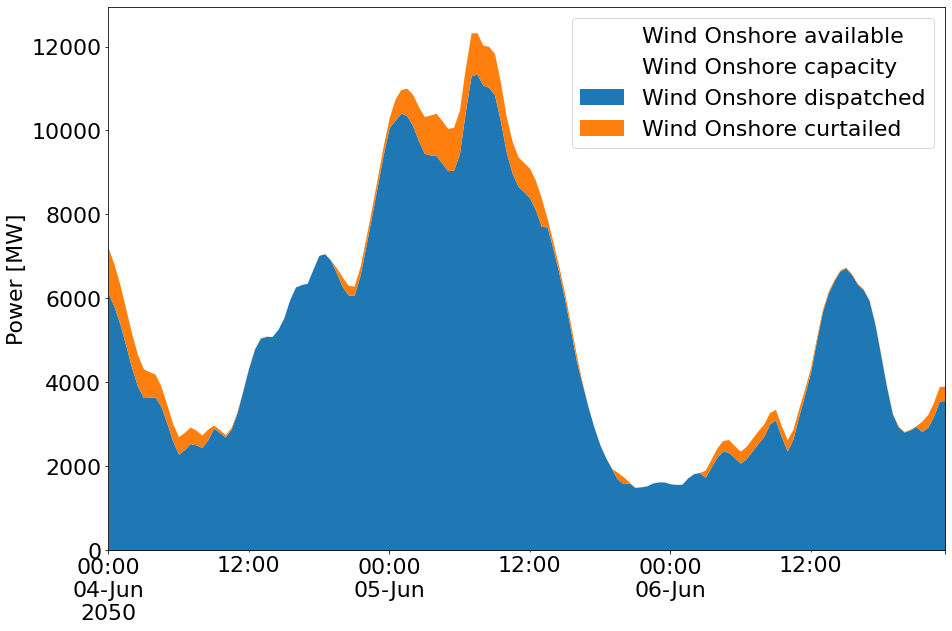

In [17]:
carrier = "Wind Onshore"

capacity = network.generators.groupby("carrier").sum().at[carrier, "p_nom"]
p_available = network.generators_t.p_max_pu.multiply(network.generators["p_nom"])
p_available_by_carrier = p_available.groupby(network.generators.carrier, axis=1).sum()
p_curtailed_by_carrier = p_available_by_carrier - p_by_carrier
p_df = pd.DataFrame({carrier + " available": p_available_by_carrier[carrier],
                     carrier + " dispatched": p_by_carrier[carrier],
                     carrier + " curtailed": p_curtailed_by_carrier[carrier]})

p_df[carrier + " capacity"] = capacity
p_df["Wind Onshore curtailed"][p_df["Wind Onshore curtailed"] < 0.] = 0.
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(15,10)
p_df[[carrier + " dispatched", carrier + " curtailed"]].plot(kind="area", ax=ax, linewidth=0)
p_df[[carrier + " available", carrier + " capacity"]].plot(ax=ax, linewidth=0)

ax.set_xlabel("")
ax.set_ylabel("Power [MW]")
ax.legend()